In [ ]:
import numpy as np
import pandas as pd
from pandas.core.common import flatten
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import io

from google.colab import drive
drive.mount('/content/drive')
#Reading the data using Pandas library


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

 A4_Q1_65.ipynb            'Copy_of_A4_Q1 (3).ipynb'     'Untitled (1)'
 A4_Q1_65_working.ipynb    'Copy_of_A4_Q1_65 (1).ipynb'   Untitled1.ipynb
'A4_Q1 [CM2].ipynb'         Copy_of_A4_Q1.ipynb          'Untitled (2)'
 A4-Q2.ipynb                COVID_dataset.csv             Untitled2.ipynb
 A4_Q2_Resnet.ipynb         COVID_dataset_Kaggle.csv     'Untitled (3)'
 A4submission_covid-2.csv   COVID_dataset_test.csv        Untitled3.ipynb
'[CM3]-COVID-FInal.ipynb'   submission_covid-02.csv      'Untitled (4)'
'Copy_of_A4_Q1 (1).ipynb'   Untitled                      Untitled4.ipynb
'Copy_of_A4_Q1 (2).ipynb'   Untitled0.ipynb


In [ ]:
cd "drive/My Drive/Colab Notebooks"

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks'
/content/drive/My Drive/Colab Notebooks


**[CM 2] - Loading data**

Data is loaded as a dataframe from a CSV file

In [ ]:
df = pd.read_csv('COVID_dataset.csv')


In [ ]:
df.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved


**[CM 2] - Data Preprocessing**

In [ ]:
#Label encoding
le = preprocessing.LabelEncoder()
#Here, we are labeling encoding the Outcome1 as Ordinal Categorical (Seriousness or severity of the outcome) data - 0 1 2
le.fit(df.Outcome1)
le.fit(['Fatal', 'Not Resolved', 'Resolved'])
le.classes_
df['Outcome1'] = le.transform(df['Outcome1'])

In [ ]:
#Here we are replacing <20 in Age_Group with 10 so that Sklearn can process it
df.loc[(df.Age_Group == '<20'),'Age_Group']='10'

#Here we are replacing the missing valves in Outbreak_Related as "No"
df['Outbreak_Related'] = df['Outbreak_Related'].fillna("No")

#Here, we are dropping any row which has any missing values.
df = df.dropna(how='any')

df = df.drop(['Test_Reported_Date'], axis = 1)
df = df.drop(['Specimen_Date'], axis = 1) 

#Here we are cleaning the 's' in the Age_Group so that sklearn accept the data
df = df.reset_index(drop=True)
df['Age_Group'] = df['Age_Group'].str.replace(r'\D', '')
df.isnull().sum(axis=0)

#Here, we are labeling encoding the Age_Group so that Sklearn treats this feature as Ordinal Categorical data

leAg = preprocessing.LabelEncoder()

leAg.fit(df.Age_Group)
leAg.fit(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
leAg.classes_
df['Age_Group'] = leAg.transform(df['Age_Group'])

leOR = preprocessing.LabelEncoder()

#Here, we are labeling encoding the Outbreak_Related as binary - 0 1
leOR.fit(df.Outbreak_Related)
leOR.fit(['Yes', 'No'])
leOR.classes_
df['Outbreak_Related'] = leOR.transform(df['Outbreak_Related'])


df_pp = df

#Here, we are dropping rows with GENDER DIVERSE (treating them as outliers) and UNSPECIFIED (treating them as missing values) 
df.drop(df[df['Client_Gender'] == 'GENDER DIVERSE'].index, inplace = True) 
df.drop(df[df['Client_Gender'] == 'UNSPECIFIED'].index, inplace = True) 
df = df.reset_index(drop=True)

#One-hot-encoding
enc = OneHotEncoder(handle_unknown='ignore')

en_CG = enc.fit_transform(df[['Client_Gender']]).toarray()
column_name_Gender = enc.get_feature_names(['Client_Gender'])
enc_df_Gender = pd.DataFrame(en_CG, columns= column_name_Gender)

en_CA = enc.fit_transform(df[['Case_AcquisitionInfo']]).toarray()
column_name_CA = enc.get_feature_names(['Case_AcquisitionInfo'])
enc_df_CA = pd.DataFrame(en_CA, columns= column_name_CA)

df = df.join(enc_df_Gender)
df = df.join(enc_df_CA)

#en_City = enc.fit_transform(df[['Reporting_PHU_City']]).toarray()
#column_name_City = enc.get_feature_names(['Reporting_PHU_City'])
#enc_df_City = pd.DataFrame(en_City, columns= column_name_City)

#df = df.join(enc_df_City)

#####################################################################
#df = df.drop(['Outbreak_Related'], axis = 1) 
#df = df.drop(['Reporting_PHU_Latitude'], axis = 1) 
#df = df.drop(['Reporting_PHU_Longitude'], axis = 1) 

df = df.drop(['Client_Gender'], axis = 1) 
df = df.drop(['Case_AcquisitionInfo'], axis = 1) 
df = df.drop(['Reporting_PHU_City'], axis = 1) 

from datetime import date

for i in range(len(df['Accurate_Episode_Date'])):
  df['Accurate_Episode_Date'][i] = (date.fromisoformat(df['Accurate_Episode_Date'][i]) - date(2019, 1, 1)).days
  df['Case_Reported_Date'][i] = (date.fromisoformat(df['Case_Reported_Date'][i]) - date(2019, 1, 1)).days
  #df['Test_Reported_Date'][i] = (date.fromisoformat(df['Test_Reported_Date'][i]) - date(2018, 1, 1)).days
  #df['Specimen_Date'][i] = (date.fromisoformat(df['Specimen_Date'][i]) - date(2018, 1, 1)).days

df_OC = df['Outcome1']
df = df.drop(['Outcome1'], axis = 1) 
dfX = df
df = df.join(df_OC)

#X = df_pp.iloc[:,:-1].values
#y = df_pp.iloc[:,7].values
X = df.iloc[:,:-1].values.astype(float)
y = df.iloc[:,14].values.astype(int)



print(df.shape)
df.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(14551, 15)


,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_MALE,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK,Outcome1
0,454,455,6,1,43.368662,-81.001913,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,752,754,4,0,44.048023,-79.480239,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,448,469,6,1,43.656591,-79.379358,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3,748,751,0,0,43.647471,-79.708893,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,725,727,5,1,42.308796,-83.033670,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2


**[CM 2] - Scaling features Reporting_PHU_Latitude and Reporting_PHU_Longitude**

**[CM 2] - Splitting data into train test and validate**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X[:,[4,5]]  = sc_X.fit_transform(X[:,[4,5]])
X[:,[0,1,]]  = sc_X.fit_transform(X[:,[0,1]])

#Split arrays or matrices into random train and test subsets
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.40, random_state = 275)
X_test, X_validate, y_test, y_validate = train_test_split(X, y, test_size=0.50, random_state = 275)

**[CM2] - Importing necessary libraries**

In [ ]:
# MLP with automatic validation set
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from keras.layers import Dense,Activation,Dropout 
from keras.layers.normalization import BatchNormalization 
from keras.utils import np_utils


**FULLY CONNECTED DEEP NEURAL NETWORK**

**Model A**

**[CM 2] - Build the architecture and Compile the model**

Model A is our first model. It has a total of 4 layers with 2 hidden layers.
We will design the NN architecture by deciding the number of layers and activation functions. 

In the first layer we translate the input dimension of 14 into 100 neurons and apply a Relu activation function.

The second layer just like the first is also a dense layer with a ReLu activation function and has 500 neurons. 

The third layer also a dense layer with a Relu activation function and 300 neurons with a dropout of 0.2. Dropout helps us find the optimum bias-variance spot.

The last layer uses a softmax activation function that classifies the 3 categories of the data and has 3 neurons.

**[CM 2] - Compiling the Model**

Next, we compile the model with the following settings:
Loss function — calculates the difference between the output and the target variable. It measures the accuracy of the model during training and we want to minimize this function. In this example, we chose the sparse_categorical_crossentropy loss function because our targets are not one-hot encoded. Its values are integers.

Optimizer — how the model is updated and is based on the data and the loss function. We use the Adam optimizer because it's shown to be effective and efficient

Metrics — monitors the training and testing steps. Accuracy is a common metric and it measures the fraction of images that are correctly classified.

In [ ]:
model_a = Sequential()
model_a.add(Dense(100, activation='relu', input_dim=14))
model_a.add(Dense(500,activation='relu'))
model_a.add(Dense(300,activation='relu'))
model_a.add(Dropout(0.2))
model_a.add(Dense(3,activation='softmax'))
#sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov=True)
model_a.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

[CM 2] - **Adding Early Stopping before fitting model**

The Early stopping added here mainly applies to the model with 50 epochs as we wanted every other epoch values to be completed


In [ ]:
from keras.callbacks import EarlyStopping
import time

early_stopping_monitor = EarlyStopping(patience=45)

start_train_time = time.time()

#Epochs - 10
history_a_10 = model_a.fit(X_train, y_train, epochs = 10, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_a_10 = model_a.evaluate(X_test, y_test, verbose = 0)

time_now_10 = time.time()
time_10 = (time_now_10 - start_train_time)
print("--- %s time to train (seconds) for 10 epochs ---" % time_10)

#Epochs - 20
history_a_20 = model_a.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_a_20 = model_a.evaluate(X_test, y_test, verbose = 0)

time_now_20 = time.time()
time_20 = (time_now_20 - time_now_10)
print("--- %s time to train (seconds) for 20 epochs ---" % time_20)

#Epochs - 30
history_a_30 = model_a.fit(X_train, y_train, epochs = 30, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_a_30 = model_a.evaluate(X_test, y_test, verbose = 0)

time_now_30 = time.time()
time_30 = (time_now_30 - time_now_20)
print("--- %s time to train (seconds) for 30 epochs ---" % time_30)

#Epochs - 40
history_a_40 = model_a.fit(X_train, y_train, epochs = 40, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_a_40 = model_a.evaluate(X_test, y_test, verbose = 0)

time_now_40 = time.time()
time_40 = (time_now_40 - time_now_30)
print("--- %s time to train (seconds) for 40 epochs ---" % time_40)

#Epochs - 50
history_a_50 = model_a.fit(X_train, y_train, epochs = 50, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_a_50 = model_a.evaluate(X_test, y_test, verbose = 0)

time_now_50 = time.time()
time_50 = (time_now_50 - time_now_40)
print("--- %s time to train (seconds) for 50 epochs ---" % time_50)

Epoch 1/10
1092/1092 [==============================] - 4s 3ms/step - loss: 0.5305 - accuracy: 0.7750 - val_loss: 0.3143 - val_accuracy: 0.8769
Epoch 2/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.3215 - accuracy: 0.8815 - val_loss: 0.2948 - val_accuracy: 0.8979
Epoch 3/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2954 - accuracy: 0.8931 - val_loss: 0.2896 - val_accuracy: 0.8936
Epoch 4/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2945 - accuracy: 0.8966 - val_loss: 0.2640 - val_accuracy: 0.9049
Epoch 5/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2801 - accuracy: 0.9001 - val_loss: 0.2491 - val_accuracy: 0.9130
Epoch 6/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2819 - accuracy: 0.8946 - val_loss: 0.2605 - val_accuracy: 0.9020
Epoch 7/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2813 - accuracy: 0.8942 - val_loss: 0.2558 - val_accuracy:

**[CM 2] - Comparing accuracies between the model fit on different number of epochs**



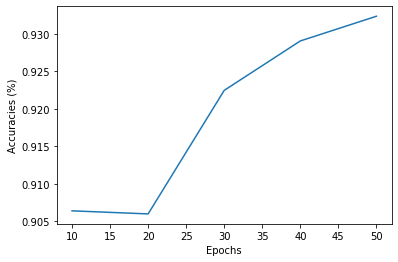

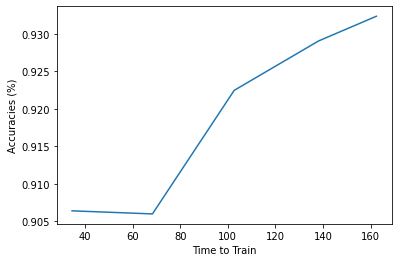

In [ ]:
#Comparing Accuracies for Model A

epochs_a = [10, 20, 30, 40, 50]
accuracies_a = [score_a_10[1], score_a_20[1],score_a_30[1],score_a_40[1],score_a_50[1]]

plt.xlabel("Epochs")
plt.ylabel("Accuracies (%)")

plt.plot(epochs_a, accuracies_a)

plt.show()

train_time_a = [time_10, time_20, time_30, time_40, time_50]
accuracies_a = [score_a_10[1], score_a_20[1],score_a_30[1],score_a_40[1],score_a_50[1]]

plt.xlabel("Time to Train")
plt.ylabel("Accuracies (%)")

plt.plot(train_time_a, accuracies_a)

plt.show()


**[CM 2]- Selecting the optimal epoch value to test on Kaggle test data**

In [ ]:
from keras.callbacks import EarlyStopping
import time

early_stopping_monitor = EarlyStopping(patience=25)

#Epochs - 30

import time

time_train_a = time.time()

history_a_30 = model_a.fit(X_train, y_train, epochs = 30, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])

time_train_a = time.time() - time_train_a

Epoch 1/30
1092/1092 [==============================] - 3s 3ms/step - loss: 0.1930 - accuracy: 0.9283 - val_loss: 0.3690 - val_accuracy: 0.9151
Epoch 2/30
1092/1092 [==============================] - 3s 3ms/step - loss: 0.1840 - accuracy: 0.9309 - val_loss: 0.3982 - val_accuracy: 0.9068
Epoch 3/30
1092/1092 [==============================] - 3s 3ms/step - loss: 0.1829 - accuracy: 0.9313 - val_loss: 0.4135 - val_accuracy: 0.9068
Epoch 4/30
1092/1092 [==============================] - 3s 3ms/step - loss: 0.1844 - accuracy: 0.9293 - val_loss: 0.3949 - val_accuracy: 0.9148
Epoch 5/30
1092/1092 [==============================] - 3s 3ms/step - loss: 0.1858 - accuracy: 0.9274 - val_loss: 0.3736 - val_accuracy: 0.9129
Epoch 6/30
1092/1092 [==============================] - 3s 3ms/step - loss: 0.1948 - accuracy: 0.9284 - val_loss: 0.3766 - val_accuracy: 0.9114
Epoch 7/30
1092/1092 [==============================] - 3s 3ms/step - loss: 0.1859 - accuracy: 0.9305 - val_loss: 0.3908 - val_accuracy:

In [ ]:
time_test_a = time.time()

score_a_30 = model_a.evaluate(X_test, y_test, verbose = 0)

time_test_a = time.time() - time_test_a

From the above graphs, When Epoch is 30 we have a fair balance of time to train and accuracy 

**[CM 2] - Plotting Accuracy and loss against number of epochs**

- It is easy to see that there exists and inverse relationship between accuracy and loss
- Subsequently we display a brief summary of the model

Test score: 0.17696747183799744
Test accuracy: 0.9338831901550293


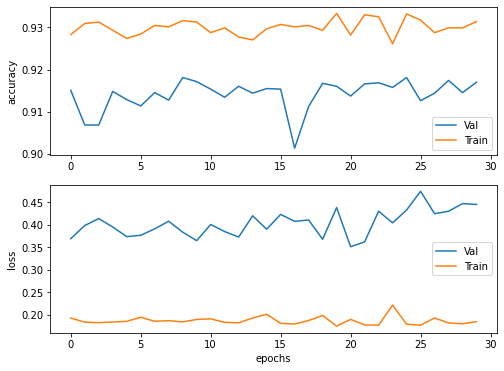

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_12 (Dense)             (None, 500)               50500     
_________________________________________________________________
dense_13 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 903       
Total params: 203,203
Trainable params: 203,203
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print('Test score:', score_a_30[0])
print('Test accuracy:', score_a_30[1])

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

acc = history_a_30.history['accuracy']
loss = history_a_30.history['loss']
val_acc = history_a_30.history['val_accuracy']
val_loss = history_a_30.history['val_loss']
ax1.plot(val_acc, label='Val')
ax1.plot(acc, label='Train')
ax2.plot(val_loss, label='Val')
ax2.plot(loss, label='Train')
    
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

print(model_a.summary())

**[CM 2] - Here we showcase the confusion matrix of the model**

In [ ]:
#import the relevant packages
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_a.predict_classes(X_test)

accuracy_default = metrics.accuracy_score(y_test, y_pred)
print(accuracy_default)

confusion_mtx = confusion_matrix(y_test, y_pred) 

print(metrics.classification_report((y_test+1),(y_pred+1)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9338831615120274
              precision    recall  f1-score   support

           1       0.89      0.93      0.91      2381
           2       0.97      0.98      0.98      2430
           3       0.94      0.89      0.91      2464

    accuracy                           0.93      7275
   macro avg       0.93      0.93      0.93      7275
weighted avg       0.93      0.93      0.93      7275



**[CM 2] -  Testing on Kaggle Test Data begins here**

In [ ]:
#@title
#This is for Kaggle
df = pd.read_csv('COVID_dataset_test.csv')
print(df.head())

#Here we are replacing <20 in Age_Group with 10 so that Sklearn can process it
df.loc[(df.Age_Group == '<20'),'Age_Group']='10'

#Here we are replacing the missing valves in Outbreak_Related as "No"
df['Outbreak_Related'] = df['Outbreak_Related'].fillna("No")

df = df.drop(['Test_Reported_Date'], axis = 1)
df = df.drop(['Specimen_Date'], axis = 1) 

#df['Test_Reported_Date'] = df['Test_Reported_Date'].fillna('4/14/2020')
#df['Specimen_Date'] = df['Specimen_Date'].fillna('4/14/2020')

#Here, we are dropping any row which has any missing values.
#df = df.dropna(how='any')

df.isnull().sum(axis=0)

#Here we are cleaning the 's' in the Age_Group so that sklearn accept the data
df = df.reset_index(drop=True)
df['Age_Group'] = df['Age_Group'].str.replace(r'\D', '')
df.isnull().sum(axis=0)


leOR = preprocessing.LabelEncoder()
leAg = preprocessing.LabelEncoder()

#Here, we are labeling encoding the Outbreak_Related as binary - 0 1
leOR.fit(df.Outbreak_Related)
leOR.fit(['Yes', 'No'])
leOR.classes_
df['Outbreak_Related'] = leOR.transform(df['Outbreak_Related'])

#Here, we are labeling encoding the Age_Group so that Sklearn treats this feature as Ordinal Categorical data
leAg.fit(df.Age_Group)
leAg.fit(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
leAg.classes_
df['Age_Group'] = leAg.transform(df['Age_Group'])

df_pp = df

#One-hot-encoding
enc = OneHotEncoder(handle_unknown='ignore')

en_CG = enc.fit_transform(df[['Client_Gender']]).toarray()
column_name_Gender = enc.get_feature_names(['Client_Gender'])
enc_df_Gender = pd.DataFrame(en_CG, columns= column_name_Gender)

en_CA = enc.fit_transform(df[['Case_AcquisitionInfo']]).toarray()
column_name_CA = enc.get_feature_names(['Case_AcquisitionInfo'])
enc_df_CA = pd.DataFrame(en_CA, columns= column_name_CA)

df = df.join(enc_df_Gender)
df = df.join(enc_df_CA)

#en_City = enc.fit_transform(df[['Reporting_PHU_City']]).toarray()
#column_name_City = enc.get_feature_names(['Reporting_PHU_City'])
#enc_df_City = pd.DataFrame(en_City, columns= column_name_City)

#df = df.join(enc_df_City)

#####################################################################
#df = df.drop(['Outbreak_Related'], axis = 1) 
#df = df.drop(['Reporting_PHU_Latitude'], axis = 1) 
#df = df.drop(['Reporting_PHU_Longitude'], axis = 1) 

df = df.drop(['Client_Gender'], axis = 1) 
df = df.drop(['Case_AcquisitionInfo'], axis = 1) 
df = df.drop(['Reporting_PHU_City'], axis = 1) 
df = df.drop(['Client_Gender_UNSPECIFIED'], axis = 1) 

from datetime import date

for i in range(len(df['Accurate_Episode_Date'])):
  df['Accurate_Episode_Date'][i] = (date.fromisoformat(df['Accurate_Episode_Date'][i]) - date(2018, 1, 1)).days
  df['Case_Reported_Date'][i] = (date.fromisoformat(df['Case_Reported_Date'][i]) - date(2018, 1, 1)).days
  #df['Test_Reported_Date'][i] = (date.fromisoformat(df['Test_Reported_Date'][i]) - date(2018, 1, 1)).days
  #df['Specimen_Date'][i] = (date.fromisoformat(df['Specimen_Date'][i]) - date(2018, 1, 1)).days

df_ID = df['id']
df = df.drop(['id'], axis = 1) 

X_FT = df.iloc[:,:].values.astype(float)

X_FT[:,[4,5]]  = sc_X.fit_transform(X_FT[:,[4,5]])
X_FT[:,[0,1]]  = sc_X.fit_transform(X_FT[:,[0,1]])

y_pred_k = model_a.predict_classes(X_FT)
print(y_pred_k)

print(df.shape)
df.head()

   id Accurate_Episode_Date  ... Reporting_PHU_Latitude Reporting_PHU_Longitude
0   0            2020-07-03  ...              43.647471              -79.708893
1   1            2021-01-05  ...              44.301632              -78.321347
2   2            2021-01-02  ...              43.656591              -79.379358
3   3            2020-12-04  ...              43.257631              -79.871341
4   4            2021-01-17  ...              43.656591              -79.379358

[5 rows x 12 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[2 0 2 ... 1 1 0]
(3704, 14)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_MALE,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK
0,914,917,2,0,43.647471,-79.708893,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1100,1108,7,0,44.301632,-78.321347,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1097,1102,5,0,43.656591,-79.379358,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1068,1069,6,1,43.257631,-79.871341,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1112,1114,3,0,43.656591,-79.379358,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


**[CM 2] - Inverse Transafrom label encoding of predicted target (This is for the Kaggle Test data too)**

In [ ]:
#@title
y_tar = le.inverse_transform(y_pred_k)
print(y_tar)
print(y_tar.shape)

['Resolved' 'Fatal' 'Resolved' ... 'Not Resolved' 'Not Resolved' 'Fatal']
(3704,)


**[CM 2] - Create CSV file containing predicted target information**

In [ ]:
#@title
my_submission = pd.DataFrame({'id': df_ID, 'Outcome1': y_tar})
my_submission.to_csv('A4submission_covid-2.csv', index=False)

**Model B - Shallow Network**

**[CM 2] - Build the architecture**

Model B is our second model and is the shallowest of the three we used here. It has a total of 3 layers with 1 hidden layers.

We will design the NN architecture by deciding the number of layers and activation functions. 

In the first layer we translate the input dimension of 14 into 100 neurons like the first model and apply a Relu activation function.

The second layer just like the first is also a dense layer with a Sigmoid activation function because the Sigmoid activation function is particularly useful for shallow networks. A dropout of 0.2 is also added to the layer.

The last layer uses a Sigmoid activation function that classifies the 3 categories of the data and has 3 neurons.



**[CM 2] - Compiling the Model**

Next, we compile the model with the following settings:
Loss function — calculates the difference between the output and the target variable. It measures the accuracy of the model during training and we want to minimize this function. In this example, we chose the sparse_categorical_crossentropy loss function because our targets are not one-hot encoded. Its values are integers.

Optimizer — how the model is updated and is based on the data and the loss function. We use the SGD optimizer here to test variety and it also works well for shallow networks.

Metrics — monitors the training and testing steps. Accuracy is a common metric and it measures the fraction of images that are correctly classified.


Just like the first model, we carry out same operations for this second

In [ ]:
model_b = Sequential()
model_b.add(Dense(100, activation='relu', input_dim=14))
model_b.add(Dense(300,activation='sigmoid'))
model_b.add(Dropout(0.2))
model_b.add(Dense(3,activation='sigmoid'))
#sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov=True)
model_b.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
start_train_time = time.time()

#Epochs - 10
history_b_10 = model_b.fit(X_train, y_train, epochs = 10, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_b_10 = model_b.evaluate(X_test, y_test, verbose = 0)

time_now_10 = time.time()
time_10 = (time_now_10 - start_train_time)
print("--- %s time to train (seconds) for 10 epochs ---" % time_10)

#Epochs - 20
history_b_20 = model_b.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_b_20 = model_b.evaluate(X_test, y_test, verbose = 0)

time_now_20 = time.time()
time_20 = (time_now_20 - time_now_10)
print("--- %s time to train (seconds) for 20 epochs ---" % time_20)

#Epochs - 30
history_b_30 = model_b.fit(X_train, y_train, epochs = 30, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_b_30 = model_b.evaluate(X_test, y_test, verbose = 0)

time_now_30 = time.time()
time_30 = (time_now_30 - time_now_20)
print("--- %s time to train (seconds) for 30 epochs ---" % time_30)

#Epochs - 40
history_b_40 = model_b.fit(X_train, y_train, epochs = 40, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_b_40 = model_b.evaluate(X_test, y_test, verbose = 0)

time_now_40 = time.time()
time_40 = (time_now_40 - time_now_30)
print("--- %s time to train (seconds) for 40 epochs ---" % time_40)

#Epochs - 50
history_b_50 = model_b.fit(X_train, y_train, epochs = 50, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_b_50 = model_b.evaluate(X_test, y_test, verbose = 0)

time_now_50 = time.time()
time_50 = (time_now_50 - time_now_40)
print("--- %s time to train (seconds) for 50 epochs ---" % time_50)

Epoch 1/10
1092/1092 [==============================] - 4s 3ms/step - loss: 0.8388 - accuracy: 0.5848 - val_loss: 0.5882 - val_accuracy: 0.7958
Epoch 2/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.6012 - accuracy: 0.7348 - val_loss: 0.4792 - val_accuracy: 0.8204
Epoch 3/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.5117 - accuracy: 0.7916 - val_loss: 0.4303 - val_accuracy: 0.8514
Epoch 4/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.4539 - accuracy: 0.8197 - val_loss: 0.3872 - val_accuracy: 0.8598
Epoch 5/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.4086 - accuracy: 0.8336 - val_loss: 0.3620 - val_accuracy: 0.8561
Epoch 6/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.3873 - accuracy: 0.8483 - val_loss: 0.3312 - val_accuracy: 0.8832
Epoch 7/10
1092/1092 [==============================] - 3s 3ms/step - loss: 0.3678 - accuracy: 0.8647 - val_loss: 0.3128 - val_accuracy:

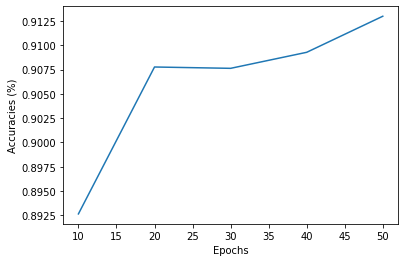

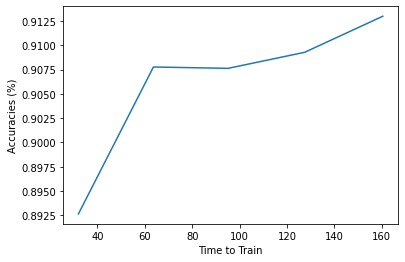

[32.01730298995972, 63.65613079071045, 95.15818285942078, 127.43999195098877, 160.39642238616943]
[0.892646074295044, 0.9077663421630859, 0.9076288938522339, 0.9092783331871033, 0.9129896759986877]
[10, 20, 30, 40, 50]


In [ ]:
#Comparing Accuracies for Model B

epochs_b = [10, 20, 30, 40, 50]
accuracies_b = [score_b_10[1], score_b_20[1],score_b_30[1],score_b_40[1],score_b_50[1]]

plt.xlabel("Epochs")
plt.ylabel("Accuracies (%)")

plt.plot(epochs_b, accuracies_b)

plt.show()

train_time_b = [time_10, time_20, time_30, time_40, time_50]
accuracies_b = [score_b_10[1], score_b_20[1],score_b_30[1],score_b_40[1],score_b_50[1]]

plt.xlabel("Time to Train")
plt.ylabel("Accuracies (%)")

plt.plot(train_time_b, accuracies_b)

plt.show()

print(train_time_b)
print(accuracies_b)

print(epochs_b)


From the above graphs, When Epoch is 20 we have the optimal use of time and highest accuracy

In [ ]:

import time

time_train_b = time.time()

history_b = model_b.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data=(X_validate, y_validate))

time_train_b = time.time() - time_train_b


Epoch 1/20
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2521 - accuracy: 0.9092 - val_loss: 0.2428 - val_accuracy: 0.9144
Epoch 2/20
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2549 - accuracy: 0.9068 - val_loss: 0.2365 - val_accuracy: 0.9171
Epoch 3/20
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2536 - accuracy: 0.9095 - val_loss: 0.2420 - val_accuracy: 0.9160
Epoch 4/20
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2511 - accuracy: 0.9104 - val_loss: 0.2436 - val_accuracy: 0.9119
Epoch 5/20
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2531 - accuracy: 0.9095 - val_loss: 0.2369 - val_accuracy: 0.9181
Epoch 6/20
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2483 - accuracy: 0.9108 - val_loss: 0.2389 - val_accuracy: 0.9155
Epoch 7/20
1092/1092 [==============================] - 3s 3ms/step - loss: 0.2529 - accuracy: 0.9108 - val_loss: 0.2478 - val_accuracy:

In [ ]:
import time

time_test_b = time.time()

score_b = model_b.evaluate(X_test, y_test, verbose = 0)

time_test_b = (time.time() - time_test_b)

print("--- %s seconds ---" % time_test_b)

--- 0.27565646171569824 seconds ---


Test score: 0.33701226115226746
Test accuracy: 0.8633676767349243


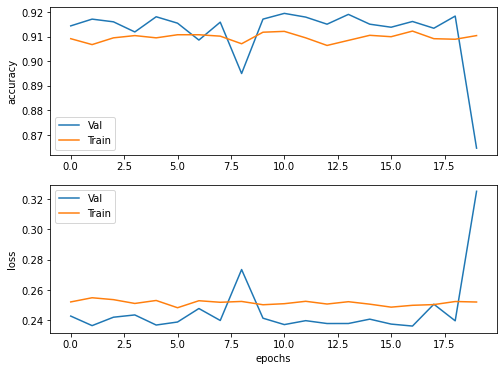

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_16 (Dense)             (None, 300)               30300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 903       
Total params: 32,703
Trainable params: 32,703
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print('Test score:', score_b[0])
print('Test accuracy:', score_b[1])

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

acc = history_b.history['accuracy']
loss = history_b.history['loss']
val_acc = history_b.history['val_accuracy']
val_loss = history_b.history['val_loss']
ax1.plot(val_acc, label='Val')
ax1.plot(acc, label='Train')
ax2.plot(val_loss, label='Val')
ax2.plot(loss, label='Train')
    
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

print(model_b.summary())

In [ ]:
#import the relevant packages
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_b.predict_classes(X_test)

accuracy_default = metrics.accuracy_score(y_test, y_pred)
print(accuracy_default)

confusion_mtx = confusion_matrix(y_test, y_pred) 

print(metrics.classification_report((y_test+1),(y_pred+1)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8633676975945017
              precision    recall  f1-score   support

           1       0.81      0.93      0.87      2381
           2       0.99      0.79      0.88      2430
           3       0.82      0.87      0.85      2464

    accuracy                           0.86      7275
   macro avg       0.88      0.86      0.86      7275
weighted avg       0.88      0.86      0.86      7275




**[CM 2] - Build the architecture**

Model C is our third and most complex model. It has a total of 4 layers with 2 hidden layers.

We will design the NN architecture by deciding the number of layers and activation functions. 

In the first layer we translate the input dimension of 14 into 10 neurons, apply batch normalization to help standardize the inputs to a layer for each mini-batch, dropout of 0.3 and apply a Relu activation function.

The second layer just like the first is also a dense layer with a Relu activation, batch normalized with a dropout of 0.3 and a regularizer which helps reduce variance.

The third layer just like the second is also a dense layer with a Relu activation with 5 neurons and then regularized.

The output layer uses a Softmax activation function that classifies the 3 categories of the data and has 3 neurons.

**[CM 2] - Compiling the Model**

Next, we compile the model with the following settings:
Loss function — calculates the difference between the output and the target variable. It measures the accuracy of the model during training and we want to minimize this function. In this example, we chose the sparse_categorical_crossentropy loss function because our targets are not one-hot encoded. Its values are integers.

Optimizer — how the model is updated and is based on the data and the loss function. We use the Adam optimizer because it's shown to be effective and efficient

Metrics — monitors the training and testing steps. Accuracy is a common metric and it measures the fraction of images that are correctly classified.

In [ ]:
from tensorflow.keras import regularizers

model_c = Sequential()
model_c.add(Dense(10, input_dim=14, activation='relu', kernel_initializer='he_normal', 
                                kernel_regularizer=regularizers.l2(0.01)))
model_c.add(BatchNormalization())
model_c.add(Dropout(0.3))
model_c.add(Dense(7, activation='relu', kernel_initializer='he_normal', 
                                kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_c.add(BatchNormalization())
model_c.add(Dropout(0.3))
model_c.add(Dense(5, activation='relu', kernel_initializer='he_normal', 
                                kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_c.add(Dense(3, activation='softmax'))

model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping
import time

early_stopping_monitor = EarlyStopping(patience=45)

start_train_time_c = time.time()

#Epochs - 10
history_c_10 = model_c.fit(X_train, y_train, epochs = 10, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_c_10 = model_c.evaluate(X_test, y_test, verbose = 0)

time_now_10 = time.time()
time_10 = (time_now_10 - start_train_time_c)
print("--- %s time to train (seconds) for 10 epochs ---" % time_10)

#Epochs - 20
history_c_20 = model_c.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_c_20 = model_c.evaluate(X_test, y_test, verbose = 0)

time_now_20 = time.time()
time_20 = (time_now_20 - time_now_10)
print("--- %s time to train (seconds) for 20 epochs ---" % time_20)

#Epochs - 30
history_c_30 = model_c.fit(X_train, y_train, epochs = 30, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_c_30 = model_c.evaluate(X_test, y_test, verbose = 0)

time_now_30 = time.time()
time_30 = (time_now_30 - time_now_20)
print("--- %s time to train (seconds) for 30 epochs ---" % time_30)

#Epochs - 40
history_c_40 = model_c.fit(X_train, y_train, epochs = 40, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_c_40 = model_c.evaluate(X_test, y_test, verbose = 0)

time_now_40 = time.time()
time_40 = (time_now_40 - time_now_30)
print("--- %s time to train (seconds) for 40 epochs ---" % time_40)

#Epochs - 50
history_c_50 = model_c.fit(X_train, y_train, epochs = 50, batch_size = 8, validation_data=(X_validate, y_validate), callbacks=[early_stopping_monitor])
score_c_50 = model_c.evaluate(X_test, y_test, verbose = 0)

time_now_50 = time.time()
time_50 = (time_now_50 - time_now_40)
print("--- %s time to train (seconds) for 50 epochs ---" % time_50)

Epoch 1/10
1092/1092 [==============================] - 6s 5ms/step - loss: 1.3123 - accuracy: 0.4130 - val_loss: 0.8371 - val_accuracy: 0.7239
Epoch 2/10
1092/1092 [==============================] - 5s 4ms/step - loss: 0.9483 - accuracy: 0.6315 - val_loss: 0.7191 - val_accuracy: 0.7974
Epoch 3/10
1092/1092 [==============================] - 5s 4ms/step - loss: 0.8192 - accuracy: 0.6910 - val_loss: 0.4926 - val_accuracy: 0.8788
Epoch 4/10
1092/1092 [==============================] - 5s 4ms/step - loss: 0.7066 - accuracy: 0.7520 - val_loss: 0.3880 - val_accuracy: 0.9026
Epoch 5/10
1092/1092 [==============================] - 5s 4ms/step - loss: 0.6172 - accuracy: 0.7927 - val_loss: 0.3539 - val_accuracy: 0.9038
Epoch 6/10
1092/1092 [==============================] - 5s 4ms/step - loss: 0.5997 - accuracy: 0.7969 - val_loss: 0.3657 - val_accuracy: 0.8950
Epoch 7/10
1092/1092 [==============================] - 5s 4ms/step - loss: 0.5893 - accuracy: 0.8064 - val_loss: 0.3151 - val_accuracy:

**Model C**

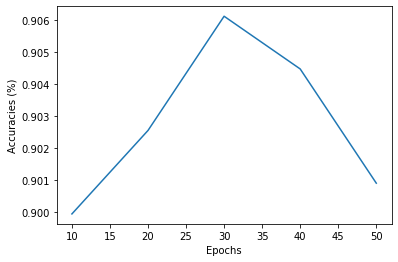

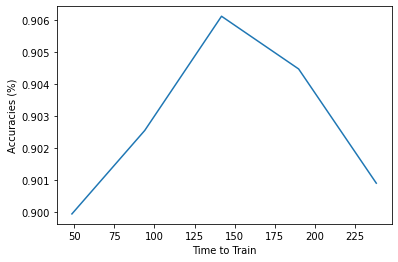

[48.54502868652344, 93.95945143699646, 141.83507752418518, 189.91387462615967, 238.33878707885742]
[0.8999312520027161, 0.9025429487228394, 0.9061168432235718, 0.9044673442840576, 0.9008934497833252]
[10, 20, 30, 40, 50]


In [ ]:
#Comparing Accuracies for Model C

epochs_c = [10, 20, 30, 40, 50]
accuracies_c = [score_c_10[1], score_c_20[1],score_c_30[1],score_c_40[1],score_c_50[1]]

plt.xlabel("Epochs")
plt.ylabel("Accuracies (%)")

plt.plot(epochs_c, accuracies_c)

plt.show()

train_time_c = [time_10, time_20, time_30, time_40, time_50]
accuracies_c = [score_c_10[1], score_c_20[1],score_c_30[1],score_c_40[1],score_c_50[1]]

plt.xlabel("Time to Train")
plt.ylabel("Accuracies (%)")

plt.plot(train_time_c, accuracies_c)

plt.show()

print(train_time_c)
print(accuracies_c)

print(epochs_c)


In [ ]:
import time

time_train_c = time.time()

history_c = model_c.fit(X_train, y_train, epochs = 30, batch_size = 8, validation_data=(X_validate, y_validate))

time_train_c = time.time() - time_train_c

Epoch 1/30
1092/1092 [==============================] - 5s 4ms/step - loss: 0.4562 - accuracy: 0.8448 - val_loss: 0.2823 - val_accuracy: 0.9140
Epoch 2/30
1092/1092 [==============================] - 5s 4ms/step - loss: 0.4376 - accuracy: 0.8550 - val_loss: 0.2862 - val_accuracy: 0.9100
Epoch 3/30
1092/1092 [==============================] - 5s 4ms/step - loss: 0.4662 - accuracy: 0.8487 - val_loss: 0.2894 - val_accuracy: 0.9129
Epoch 4/30
1092/1092 [==============================] - 5s 4ms/step - loss: 0.4237 - accuracy: 0.8595 - val_loss: 0.2981 - val_accuracy: 0.9034
Epoch 5/30
1092/1092 [==============================] - 5s 4ms/step - loss: 0.4558 - accuracy: 0.8480 - val_loss: 0.3006 - val_accuracy: 0.9030
Epoch 6/30
1092/1092 [==============================] - 5s 4ms/step - loss: 0.4481 - accuracy: 0.8559 - val_loss: 0.2924 - val_accuracy: 0.9089
Epoch 7/30
1092/1092 [==============================] - 5s 4ms/step - loss: 0.4450 - accuracy: 0.8506 - val_loss: 0.2989 - val_accuracy:

In [ ]:
import time

time_test_c = time.time()

score_c = model_c.evaluate(X_test, y_test, verbose = 0)

time_test_c = (time.time() - time_test_c)

print("--- %s seconds ---" % time_test_c)

--- 0.32587480545043945 seconds ---


Test score: 0.30102548003196716
Test accuracy: 0.9063917398452759


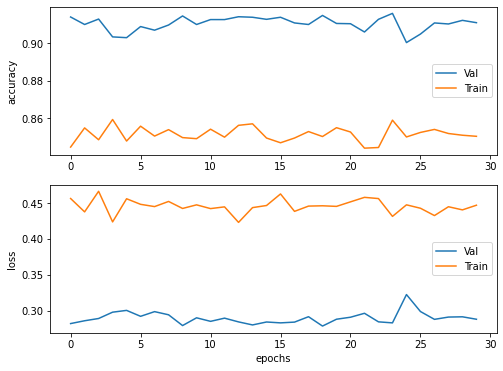

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                150       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)                40        
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 77        
_________________________________________________________________
batch_normalization_3 (Batch (None, 7)                 28        
_________________________________________________________________
dropout_7 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                

In [ ]:
print('Test score:', score_c[0])
print('Test accuracy:', score_c[1])

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

acc = history_c.history['accuracy']
loss = history_c.history['loss']
val_acc = history_c.history['val_accuracy']
val_loss = history_c.history['val_loss']
ax1.plot(val_acc, label='Val')
ax1.plot(acc, label='Train')
ax2.plot(val_loss, label='Val')
ax2.plot(loss, label='Train')
    
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

print(model_c.summary())

Resources
- https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b

**Comparing models**

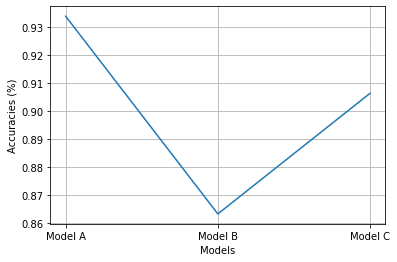

In [ ]:
models = [1, 2, 3]
accuracies = [score_a_30[1], score_b[1], score_c[1]]

plt.grid()
plt.xlabel("Models")
plt.ylabel("Accuracies (%)")

labels = ["Model A", "Model B", "Model C"]

plt.xticks(models, labels)

plt.plot(models, accuracies)

plt.show()


models = [1, 2, 3]
losses = [score_a_30[0], score_b[0], score_c[0]]

plt.grid()
plt.xlabel("Models")
plt.ylabel("losses (%)")

labels = ["Model A", "Model B", "Model C"]

plt.xticks(models, labels)

plt.plot(models, losses)

plt.show()

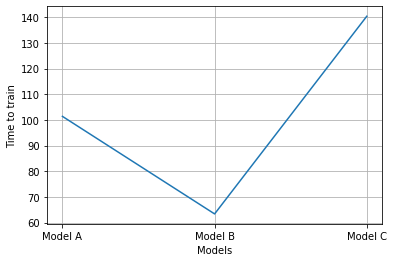

In [ ]:

models = [1, 2, 3]
time_to_trains = [time_train_a, time_train_b, time_train_c]

plt.grid()
plt.xlabel("Models")
plt.ylabel("Time to train")

labels = ["Model A", "Model B", "Model C"]

plt.xticks(models, labels)

plt.plot(models, time_to_trains)

plt.show()

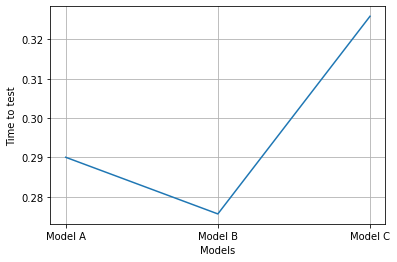

In [ ]:
models = [1, 2, 3]
time_to_test = [time_test_a, time_test_b, time_test_c]

plt.grid()
plt.xlabel("Models")
plt.ylabel("Time to test")

labels = ["Model A", "Model B", "Model C"]

plt.xticks(models, labels)

plt.plot(models, time_to_test)

plt.show()